In [8]:
import numpy as np
import matplotlib.pyplot as plt
import kernel

t = np.linspace(0, 1, 500)
dim = len(t)
# 2. ランダムシードの固定（再現性のため）
np.random.seed(42)
n_samples=5

In [17]:
# 1. パラメータの設定
# 平均ベクトル (Mean vector)
mean = t*2
# 共分散行列 (Covariance matrix)
# [[分散X, 共分散], [共分散, 分散Y]]
# ここではXとYに強い正の相関(0.8)を持たせています
cov = kernel.smooth_bridge_kernel(t,epsilon=0.01)


In [18]:
# 3. サンプリングの実行
# dataは (1000, 2) の配列になります
data = np.random.multivariate_normal(mean, cov, n_samples)

/var/folders/k1/fppyl5092px_ry865m02bsph0000gn/T/ipykernel_15830/2851823312.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean, cov, n_samples)


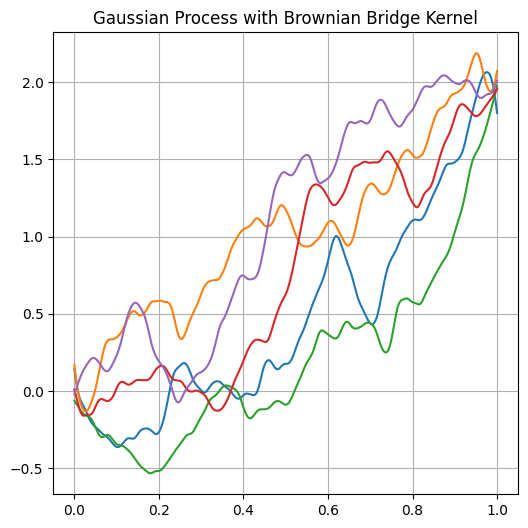

In [19]:
plt.figure(figsize=(6, 6))
for ft in data:
    plt.plot(t, ft)
plt.title("Gaussian Process with Brownian Bridge Kernel")
plt.grid(True)
plt.show()